This notebook incorporates the WhiteNoise kernel to produce error bar charts and parity plots per round. This is based on helpful discussions with Jaron Thompson on 8-01-24.

# Header Material

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import json
import scipy.stats as ss

from sklearn.gaussian_process import GaussianProcessRegressor,kernels
from sklearn.model_selection import train_test_split, KFold,LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [3]:
from src.models.constants import Constants
from src.models import util
from src.models.gaussian_process import featurize

In [4]:
plt.style.use('seaborn-v0_8-talk')
cmap = plt.get_cmap("tab10")
raw_dir = "D:/ukuru/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/raw"
processed_dir = "D:/ukuru/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/processed"
n_map = {1:"Base",2:"Thru Rnd 1",3:"Thru Rnd 2",4:"Thru Rnd 3",5:"Thru Rnd 4",6:"Thru Rnd 5",7:"Thru Rnd 6-GP"}
seed=0
df2 = pd.read_csv(processed_dir+"/"+"2-cleanedup_Round8-Standardized.csv")
print(df2.shape)
df2.head()

(140, 20)


,Unnamed: 0,Catalyst,Reaction,Tube,Date,Mass Catalyst,Mass Diluent,k_d,Y0,lifetime_yield,Y_pc,sqrtY0Y_pc,Pt,Sn,Ga,Fe,Cu,Ca,Mn,Zn
0,0,Pt1/γ-Al2O3 2/5/24,24-005,1,2024-02-05,20.0,120.2,0.011951,0.093141,7.793377,7.350753,0.827439,1,0.0,0.0,0.0,0.0,0.0,0,0
1,1,Pt1/γ-Al2O3 2/5/24,24-005,2,2024-02-05,20.1,120.0,0.011695,0.138308,11.826379,11.112063,1.239711,1,0.0,0.0,0.0,0.0,0.0,0,0
2,2,Pt1/γ-Al2O3 2/5/24,24-005,3,2024-02-05,20.0,120.0,0.010522,0.063163,6.002886,5.522449,0.590604,1,0.0,0.0,0.0,0.0,0.0,0,0
3,3,Pt1/γ-Al2O3 2/5/24,24-005,4,2024-02-05,20.0,120.0,0.009353,0.055320,5.915015,5.288208,0.540875,1,0.0,0.0,0.0,0.0,0.0,0,0
4,4,Pt1/γ-Al2O3 2/5/24,24-005,5,2024-02-05,20.1,120.2,0.009263,0.062064,6.700162,5.974731,0.608945,1,0.0,0.0,0.0,0.0,0.0,0,0


In [6]:
Sets = {"Training":["005","006","007","008","009","010","011","015","016"],
        "Round 1":["005","006","007","008","009","010","011","015","016","023"],
       "Round 2":["005","006","007","008","009","010","011","015","016","023","025"],
       "Round 3":["005","006","007","008","009","010","011","015","016","023","025","030"],
       "Round 4":["005","006","007","008","009","010","011","015","016","023","025","030","031"],
        "Round 5 GP":["005","006","007","008","009","010","011","015","016","023","025","030","031","034"],
        "Round 6 GP":["005","006","007","008","009","010","011","015","016","023","025","030","031","034","038"],
        "Round 5 KNN":["005","006","007","008","009","010","011","015","016","023","025","030","031","035"],
        "Round 6 KNN":["005","006","007","008","009","010","011","015","016","023","025","030","031","035","049"],
       "Coarse Grid":["005","006","007","008","009","010","011","015","016","023","025","030","031"],
        "Fine Grid":["005","006","007","008","009","010","011","015","016","023","025","030","031","034","035","038","049"],
        "Replicate Runs":["005","006","007","008","009","010","011","015","016","023","025","030","031","034","035","038","049","050","051","052","053","054","055","056","058","061"],
        "Final Round":["005","006","007","008","009","010","011","015","016","023","025","030","031","034","035","038","049","050","051","052","053","054","055","056","058","061","064"]}


In [8]:
def remove_duplicates(X_train,X_test,y_train,y_test,verbose=False,duplicate_if_different_tubes=True):
    idx_to_remove = []
    for i in range(X_test.shape[0]): #for each test datapoint:
        for j in range(X_train.shape[0]):
            if duplicate_if_different_tubes: #if same cat tested in diff tubes consider this a duplicate
                n=1
            else:
                n=0
                
            if np.array_equal(X_test[i,n:],X_train[j,n:]):
                if verbose:
                    print("Found equal")
                    print(X_test[i,:])
                    print(X_train[j,:])
                idx_to_remove.append(j)
    return np.delete(X_train,idx_to_remove,axis=0),np.delete(y_train,idx_to_remove,axis=0)

# Learning Rate

In [9]:
df2['Reaction'] = df2['Reaction'].str.replace('24-','')
df2["diversity"] = df2[["Pt","Sn","Ga","Fe","Cu","Ca"]].astype(bool).sum(axis=1)
df2["loading"] = df2[["Pt","Sn","Ga","Fe","Cu","Ca"]].sum(axis=1)
header=["Tube","Sn","Ga","Fe","Cu","Ca","diversity","loading"]
res = {"mae":{},"r2":{},"mae_norm":{},"rmse":{},"rmse_norm":{},"r2_train":{},"mae_train":{},"rmse_train":{}}
vals = {}
rng = np.random.default_rng(seed=seed)
a=np.array(df2.index)
for i in range(50):
    rng.shuffle(a)
    n_test = int(0.1*len(a)) #10% of total dataset
    test = a[0:n_test]
    train = a[n_test:]
    n_arr = [int(pct*len(train)) for pct in [0.2,0.4,0.6,0.8,1]]
    
    df_test = df2.iloc[test,:]
    X_test = df_test[header].to_numpy()
    y_test = df_test["sqrtY0Y_pc"].to_numpy()

    for n in n_arr:
        train_subset = train[0:n]
        df_sel = df2.iloc[train_subset,:]

        X_train = df_sel[header].to_numpy()
        y_train = df_sel["sqrtY0Y_pc"].to_numpy()

        X_train,y_train = remove_duplicates(X_train,X_test,y_train,y_test) #avoid leakage by removing identical entries


        y_train = np.hstack((y_train.reshape(-1,1),np.zeros(y_train.shape[0]).reshape(-1,1))) #add an extra col of 0s
        mu,sigma = util.GP_regressor(X_train,y_train,X_test,verbose=False,
                                     args={'kernel_type':'RBF+White','seed':seed,'use_sd_sample':False})

    #        kernel = 1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2))+kernels.WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))

    #        pipeline = make_pipeline(GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5,random_state=seed))
    #        pipeline.fit(X_train,y_train)
    #        y_pred,y_pred_std = pipeline.predict(X_test,return_std=True)
    #        y_preds.append(y_pred[0])
    #        y_stds.append(y_pred_std[0])
    #        y_actuals.append(y_test[0])

        pred = np.asarray(mu)
        expt = np.asarray(y_test)
        stds = np.asarray(sigma)




        mae = np.mean(np.abs(pred-expt))
        slope, intercept, r_value, p_value, std_err = ss.linregress(expt,pred)
        r2 = r_value**2
        rmse = np.sqrt(mean_squared_error(expt,pred))
        mae_norm = np.mean(np.abs(pred-expt)/expt)
        rmse_norm = rmse / np.mean(expt)


        kernel = 1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2))+kernels.WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))

        pipeline = make_pipeline(GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5,random_state=seed,alpha=0))
        pipeline.fit(X_train,y_train[:,0])
        y_pred,y_pred_std = pipeline.predict(X_train,return_std=True)
        slope, intercept, r_value, p_value, std_err = ss.linregress(y_train[:,0],y_pred)
        r2_train = r_value**2
        mae_train = np.mean(np.abs(y_pred-y_train[:,0]))
        rmse_train = np.sqrt(mean_squared_error(y_train[:,0],y_pred))
        if i == 0:
            res["r2_train"][n]=[r2_train]
            res["mae_train"][n]=[mae_train]
            res["rmse_train"][n]=[rmse_train]
            res["rmse"][n]=[rmse]
            res["r2"][n]=[r2]
            res["mae_norm"][n]=[mae_norm]
            res["mae"][n]=[mae]
            res["rmse_norm"][n]=[rmse_norm]
        else:
            res["r2_train"][n].append(r2_train)
            res["mae_train"][n].append(mae_train)
            res["rmse_train"][n].append(rmse_train)
            res["rmse"][n].append(rmse)
            res["r2"][n].append(r2)
            res["mae_norm"][n].append(mae_norm)
            res["mae"][n].append(mae)
            res["rmse_norm"][n].append(rmse_norm)
        label=f'{n}_{i} MAE {mae:.3} RMSE {rmse:.3} R2: {r2:.3} R2_Train: {r2_train:.3}'  

        print(label)



25_0 MAE 0.688 RMSE 0.828 R2: 0.255 R2_Train: 0.922
50_0 MAE 0.766 RMSE 0.96 R2: 0.242 R2_Train: 0.932
75_0 MAE 0.71 RMSE 0.828 R2: 0.286 R2_Train: 0.888
100_0 MAE 0.696 RMSE 0.808 R2: 0.314 R2_Train: 0.867
126_0 MAE 0.685 RMSE 0.788 R2: 0.329 R2_Train: 0.867
25_1 MAE 0.519 RMSE 0.67 R2: 0.452 R2_Train: 0.868
50_1 MAE 0.515 RMSE 0.618 R2: 0.652 R2_Train: 0.897
75_1 MAE 0.586 RMSE 0.684 R2: 0.631 R2_Train: 0.883
100_1 MAE 0.557 RMSE 0.671 R2: 0.695 R2_Train: 0.871
126_1 MAE 0.532 RMSE 0.632 R2: 0.746 R2_Train: 0.859
25_2 MAE 0.532 RMSE 0.663 R2: 0.831 R2_Train: 0.978
50_2 MAE 0.555 RMSE 0.69 R2: 0.778 R2_Train: 0.898
75_2 MAE 0.628 RMSE 0.776 R2: 0.746 R2_Train: 0.857
100_2 MAE 0.627 RMSE 0.806 R2: 0.68 R2_Train: 0.88
126_2 MAE 0.585 RMSE 0.742 R2: 0.774 R2_Train: 0.856
25_3 MAE 0.365 RMSE 0.444 R2: 0.446 R2_Train: 0.849
50_3 MAE 0.343 RMSE 0.454 R2: 0.555 R2_Train: 0.865
75_3 MAE 0.286 RMSE 0.379 R2: 0.527 R2_Train: 0.814
100_3 MAE 0.448 RMSE 0.536 R2: 0.258 R2_Train: 0.9
126_3 MAE 0.4

D:\ukuru\anaconda3\envs\ml-env\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
D:\ukuru\anaconda3\envs\ml-env\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


25_12 MAE 0.81 RMSE 0.95 R2: 0.00765 R2_Train: 1.0
50_12 MAE 0.542 RMSE 0.656 R2: 0.59 R2_Train: 0.832
75_12 MAE 0.537 RMSE 0.639 R2: 0.594 R2_Train: 0.82
100_12 MAE 0.508 RMSE 0.601 R2: 0.615 R2_Train: 0.876
126_12 MAE 0.563 RMSE 0.671 R2: 0.541 R2_Train: 0.874
25_13 MAE 1.16 RMSE 1.42 R2: 0.469 R2_Train: 0.354
50_13 MAE 1.06 RMSE 1.29 R2: 0.322 R2_Train: 0.766
75_13 MAE 1.06 RMSE 1.25 R2: 0.365 R2_Train: 0.751
100_13 MAE 0.85 RMSE 1.08 R2: 0.582 R2_Train: 0.861
126_13 MAE 0.875 RMSE 1.08 R2: 0.609 R2_Train: 0.846
25_14 MAE 0.739 RMSE 0.842 R2: 0.765 R2_Train: 0.975
50_14 MAE 0.577 RMSE 0.768 R2: 0.828 R2_Train: 0.867
75_14 MAE 0.526 RMSE 0.696 R2: 0.739 R2_Train: 0.9
100_14 MAE 0.559 RMSE 0.696 R2: 0.807 R2_Train: 0.833
126_14 MAE 0.565 RMSE 0.762 R2: 0.816 R2_Train: 0.802
25_15 MAE 0.575 RMSE 0.825 R2: 0.589 R2_Train: 0.999
50_15 MAE 0.626 RMSE 0.807 R2: 0.63 R2_Train: 1.0
75_15 MAE 0.481 RMSE 0.564 R2: 0.801 R2_Train: 0.789
100_15 MAE 0.491 RMSE 0.603 R2: 0.836 R2_Train: 0.753
126_

50_43 MAE 0.478 RMSE 0.561 R2: 0.246 R2_Train: 0.731
75_43 MAE 0.442 RMSE 0.628 R2: 0.395 R2_Train: 0.83
100_43 MAE 0.553 RMSE 0.738 R2: 0.383 R2_Train: 0.879
126_43 MAE 0.557 RMSE 0.742 R2: 0.435 R2_Train: 0.878
25_44 MAE 0.846 RMSE 1.02 R2: 0.122 R2_Train: 0.887
50_44 MAE 0.825 RMSE 1.04 R2: 0.118 R2_Train: 0.903
75_44 MAE 0.785 RMSE 1.0 R2: 0.17 R2_Train: 0.878
100_44 MAE 0.76 RMSE 0.946 R2: 0.242 R2_Train: 0.844
126_44 MAE 0.808 RMSE 0.972 R2: 0.252 R2_Train: 0.851
25_45 MAE 0.722 RMSE 0.838 R2: 0.594 R2_Train: 0.961
50_45 MAE 0.725 RMSE 0.872 R2: 0.542 R2_Train: 0.893
75_45 MAE 0.832 RMSE 1.07 R2: 0.298 R2_Train: 0.816
100_45 MAE 0.638 RMSE 0.767 R2: 0.722 R2_Train: 0.83
126_45 MAE 0.565 RMSE 0.677 R2: 0.775 R2_Train: 0.863
25_46 MAE 0.778 RMSE 1.07 R2: 0.361 R2_Train: 0.855
50_46 MAE 0.755 RMSE 1.01 R2: 0.435 R2_Train: 0.932
75_46 MAE 0.744 RMSE 0.996 R2: 0.463 R2_Train: 0.866
100_46 MAE 0.792 RMSE 1.04 R2: 0.429 R2_Train: 0.837
126_46 MAE 0.82 RMSE 1.01 R2: 0.458 R2_Train: 0.781

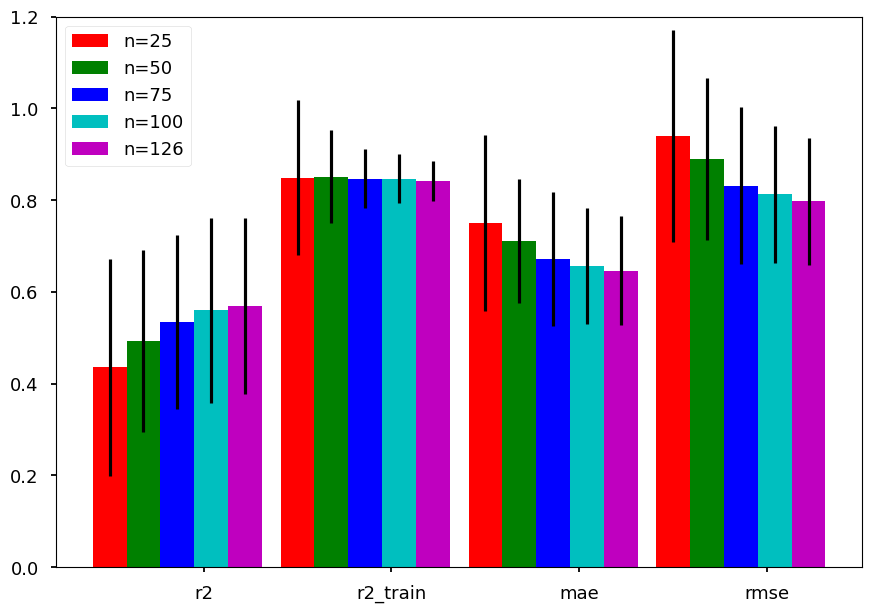

In [11]:
to_json = {"r2":{},"r2_train":{},"mae":{},"rmse":{}}
width =0.9/len(res['r2'].keys())
scores = {"r2":0,"r2_train":1,"mae":2,"rmse":3}
names = res['r2'].keys() #names of various rounds
color_list = ['r','g','b','c','m','y','k','darkorange','palegreen','fuchsia','olive']
#https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots()
for i,val in enumerate(['r2','r2_train','mae','rmse']):
    for j,name in enumerate(names):
        arr = np.array(res[val][name])
        avg = np.average(arr)
        err = 1*np.std(arr)
        to_json[val][name]={"avg":avg,"err":err}
        if val == 'r2':
            ax.bar(scores[val]+j*width,avg,width=width,color=color_list[j],label=f'n={name}',yerr=err)
        else: #no label to prevent repeats
            ax.bar(scores[val]+j*width,avg,width=width,color=color_list[j],yerr=err)
plt.xticks(np.asarray(list(scores.values()))+.5,list(scores.keys()))
# plt.title("Leave one out CV without duplicates")
plt.legend(loc='upper left')
plt.ylim((0,1.2))
plt.show()
#plt.savefig("./figures/LOO-CV Learning Rate 10pct holdout 50 replicates.png",dpi=600,bbox_inches='tight')



In [13]:
#with open('./manuscript_figures/learning-rate-all-data.json', 'w', encoding='utf-8') as f:
#    json.dump(to_json, f, ensure_ascii=False, indent=4)

# DTL-KFold (Zavala Lab Approach)

In [15]:
df2['Reaction'] = df2['Reaction'].str.replace('24-','')
df2["diversity"] = df2[["Pt","Sn","Ga","Fe","Cu","Ca"]].astype(bool).sum(axis=1)
df2["loading"] = df2[["Pt","Sn","Ga","Fe","Cu","Ca"]].sum(axis=1)
header=["Tube","Sn","Ga","Fe","Cu","Ca","diversity","loading"]
res = {"mae":{},"r2":{},"mae_norm":{},"rmse":{},"rmse_norm":{},"r2_train":{},"mae_train":{},"rmse_train":{}}
vals = {}
for name in ["Training","Coarse Grid","Fine Grid","Replicate Runs","Final Round"]:
    rxns = Sets[name]
    df_sel = df2[df2["Reaction"].isin(rxns)]
    df_addl = df2[~df2["Reaction"].isin(rxns)]

    X = df_sel[header].to_numpy()
    y = df_sel["sqrtY0Y_pc"].to_numpy()
    
    X_addl = df_addl[header].to_numpy()
    y_addl = df_addl["sqrtY0Y_pc"].to_numpy()
    
    print(name,rxns,X.shape)
    n = X.shape[0]
    y_preds = []
    y_stds = []
    y_actuals = []
    loo = KFold(n_splits=n)
    for train_index,test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train,y_train = remove_duplicates(X_train,X_test,y_train,y_test) #avoid leakage by removing identical entries

        
        y_train = np.hstack((y_train.reshape(-1,1),np.zeros(y_train.shape[0]).reshape(-1,1))) #add an extra col of 0s
        mu,sigma = util.GP_regressor(X_train,y_train,X_test,verbose=False,
                                     args={'kernel_type':'RBF+White','seed':seed,'use_sd_sample':False})
        y_preds.append(mu[0])
        y_stds.append(sigma[0])
        y_actuals.append(y_test[0])
#        kernel = 1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2))+kernels.WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
        
#        pipeline = make_pipeline(GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5,random_state=seed))
#        pipeline.fit(X_train,y_train)
#        y_pred,y_pred_std = pipeline.predict(X_test,return_std=True)
#        y_preds.append(y_pred[0])
#        y_stds.append(y_pred_std[0])
#        y_actuals.append(y_test[0])
    for i in range(X_addl.shape[0]): #for additional datapoints
        X_test = X_addl[i,:].reshape(1,-1) #only 1d arr
        y_test = y_addl[i]
        X_train,y_train = remove_duplicates(X,X_test,y,y_test)

        
        y_train = np.hstack((y_train.reshape(-1,1),np.zeros(y_train.shape[0]).reshape(-1,1))) #add an extra col of 0s
        mu,sigma = util.GP_regressor(X_train,y_train,X_test,verbose=False,
                                     args={'kernel_type':'RBF+White','seed':seed,'use_sd_sample':False})
        y_preds.append(mu[0])
        y_stds.append(sigma[0])
        y_actuals.append(y_test)
    pred = np.asarray(y_preds)
    expt = np.asarray(y_actuals)
    stds = np.asarray(y_stds)
    vals[name] = {"pred":pred,"expt":expt,"std":stds}



    mae = np.mean(np.abs(pred-expt))
    slope, intercept, r_value, p_value, std_err = ss.linregress(expt,pred)
    r2 = r_value**2
    rmse = np.sqrt(mean_squared_error(expt,pred))
    mae_norm = np.mean(np.abs(pred-expt)/expt)
    rmse_norm = rmse / np.mean(expt)

    res["rmse"][name]=rmse
    res["r2"][name]=r2
    res["mae_norm"][name]=mae_norm
    res["mae"][name]=mae
    res["rmse_norm"][name]=rmse_norm

    kernel = 1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2))+kernels.WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
        
    pipeline = make_pipeline(GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5,random_state=seed,alpha=0))
    pipeline.fit(X,y)
    y_pred,y_pred_std = pipeline.predict(X,return_std=True)
    slope, intercept, r_value, p_value, std_err = ss.linregress(y,y_pred)
    r2_train = r_value**2
    mae_train = np.mean(np.abs(y_pred-y))
    rmse_train = np.sqrt(mean_squared_error(y,y_pred))
    res["r2_train"][name]=r2_train
    res["mae_train"][name]=mae_train
    res["rmse_train"][name]=rmse_train
    vals[name]["train_pred"] = np.asarray(y_pred)
    vals[name]["train_expt"] = np.asarray(y)
    vals[name]["train_std"] = np.asarray(y_pred_std)

    label=f'{name} MAE {mae:.3} RMSE {rmse:.3} R2: {r2:.3} R2_Train: {r2_train:.3}'  

    print(label)



Training ['005', '006', '007', '008', '009', '010', '011', '015', '016'] (40, 8)
Training MAE 0.868 RMSE 1.09 R2: 0.332 R2_Train: 0.934
Coarse Grid ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030', '031'] (64, 8)
Coarse Grid MAE 0.784 RMSE 0.939 R2: 0.455 R2_Train: 0.867
Fine Grid ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030', '031', '034', '035', '038', '049'] (88, 8)
Fine Grid MAE 0.698 RMSE 0.862 R2: 0.53 R2_Train: 0.874
Replicate Runs ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030', '031', '034', '035', '038', '049', '050', '051', '052', '053', '054', '055', '056', '058', '061'] (134, 8)
Replicate Runs MAE 0.68 RMSE 0.849 R2: 0.519 R2_Train: 0.904
Final Round ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030', '031', '034', '035', '038', '049', '050', '051', '052', '053', '054', '055', '056', '058', '061', '064'] (140, 8)
Final Round MAE 0.67

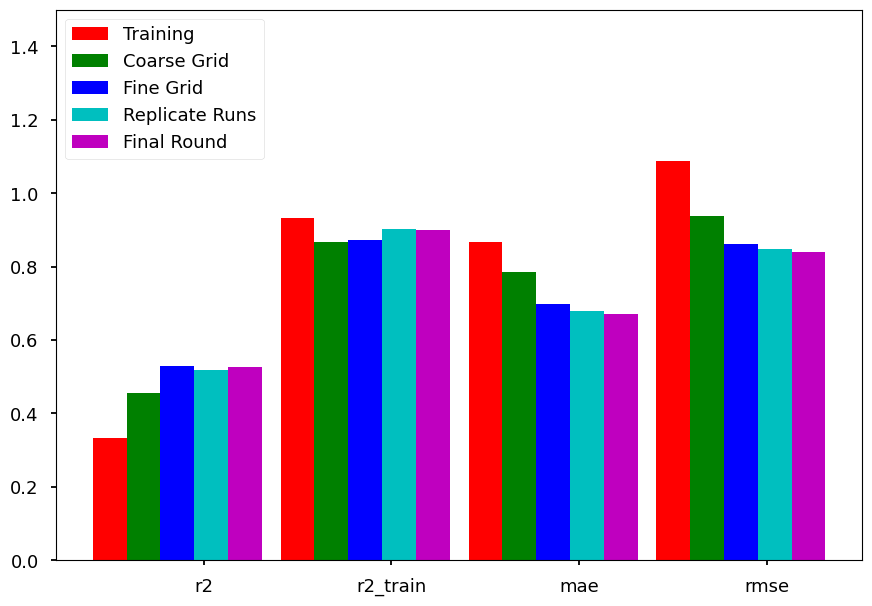

In [16]:
to_json = {"r2":{},"r2_train":{},"mae":{},"rmse":{}}
width =0.9/len(vals.keys())
scores = {"r2":0,"r2_train":1,"mae":2,"rmse":3}
names = res['r2'].keys() #names of various rounds
color_list = ['r','g','b','c','m','y','k','darkorange','palegreen','fuchsia','olive']
#https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots()
for i,val in enumerate(['r2','r2_train','mae','rmse']):
    for j,name in enumerate(names):
        to_json[val][name] = res[val][name]
        if val == 'r2':
            ax.bar(scores[val]+j*width,res[val][name],width=width,color=color_list[j],label=name)
        else: #no label to prevent repeats
            ax.bar(scores[val]+j*width,res[val][name],width=width,color=color_list[j])
plt.xticks(np.asarray(list(scores.values()))+.5,list(scores.keys()))
#plt.title("Leave one out CV without duplicates")
plt.legend(loc='upper left')
plt.ylim((0,1.5))
plt.show()
#plt.savefig("./figures/DTL K-Fold.png",dpi=600,bbox_inches='tight')

In [18]:
#with open('./manuscript_figures/dtl-k-fold-zavala-lab-all-data.json', 'w', encoding='utf-8') as f:
#    json.dump(to_json, f, ensure_ascii=False, indent=4)